# 04: Inference

In this notebook, we'll use the trained model to make predictions on new NAIP imagery.

In [62]:
import matplotlib.pyplot as plt
import wandb

from naip_cnn.inference import NAIPTFRecord
from naip_cnn.models import ModelRun

## Load the Model

First, we'll load and inspect the previously trained model.

In [100]:
model_run = ModelRun.from_wandb_run("aazuspan-team/naip-cnn/ag25ku6j")
model_run.model.summary()

wandb:   1 of 1 files downloaded.  


Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 30, 30, 4)]       0         
                                                                 
 conv2d_76 (Conv2D)          (None, 30, 30, 16)        592       
                                                                 
 conv2d_77 (Conv2D)          (None, 30, 30, 16)        2320      
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 15, 15, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_36 (Dropout)        (None, 15, 15, 16)        0         
                                                                 
 conv2d_78 (Conv2D)          (None, 15, 15, 32)        4640      
                                                               

## Run Inference

Inference is run on NAIP images that were exported as TFRecords in the previous notebook. Before continuing, make sure to wait for all Earth Engine exports to complete (you can check progress in the [task manager](https://code.earthengine.google.com/tasks)) and download the exported files to local storage.

In [101]:
naip = NAIPTFRecord(
    id="MAL",
    footprint=model_run.dataset.footprint,
    res=model_run.dataset.naip_res,
    year=2016,
)

### Generate Predictions

Now we can use the model to generate predictions on the input images.

In [102]:
pred = naip.predict(run=model_run, verbose=1)

10547/10547 [==============================] - 177s 17ms/step


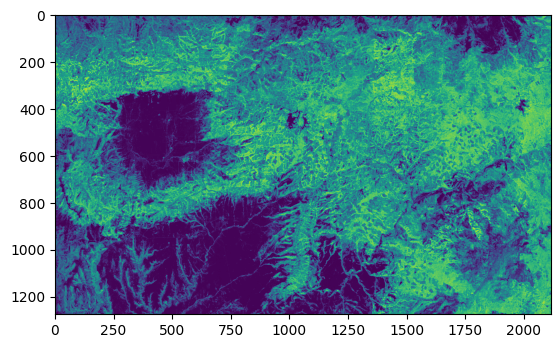

In [103]:
plt.imshow(pred, vmin=0, vmax=100)

## Export Predictions

Finally, we can export the predicted map to a raster image.

In [104]:
naip.export_prediction(pred=pred, run=model_run)

PosixPath('../data/pred/MAL-2016-1-30x30-CNN-MAL2016_CanyonCreek-1-30-30x30-30-cover-RGBN.tif')